# Paper 2 — Logit: Recession Probability from the Yield Curve (12-Month Horizon)

**Files expected** (same folder as this notebook):

- `yields_monthly.csv` (or `treasury_yield.csv`) with columns: `Date`, `3m` (or `DGS3MO`), `2y` (or `DGS2`), `10y` (or `DGS10`) — monthly EOM or monthly average; `Date` in YYYY-MM-DD format. 30Y not required.  
- `usrec_monthly.csv` with columns: `Date`, `USREC` (NBER recession indicator; 1 = recession, 0 = expansion).

**Method:** Logistic regression with an expanding-window (walk-forward) backtest to predict `USREC` 12 months ahead using the 10Y–3M and 10Y–2Y spreads, plus 1- and 6-month lags.

**Outputs:** ROC/AUC, precision/recall snapshot, full-history probability series with NBER shading, zoomed last-10-years view, and an optional `statsmodels` coefficient table.

**Companion Article:**  
*When the Curve Speaks: Estimating Recession Risk with a Logistic Classification Model*  
[https://thebaselpoint.substack.com/p/when-the-curve-speaks](https://thebaselpoint.substack.com/p/when-the-curve-speaks)

**Repository:** [yield-inversion-paper-2](https://github.com/basel-point/yield-inversion-paper-2)

---

**Note:** This is a redacted preview notebook prepared for publication.  
Full implementation details are withheld.

© 2025 *The Basel Point Research.* Prepared by **S.Y. Kim** (<thebaselpoint@gmail.com>).


In [1]:

# 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm  # for nice Logit summary (optional)
import warnings
from pathlib import Path

# Plot defaults
plt.rcParams['figure.figsize'] = (9, 4)
plt.rcParams['axes.grid'] = True

warnings.filterwarnings('ignore')


In [2]:

# 1. Load data (robust to names/paths); trims to 1957+ by default

# Optional explicit paths:
# PATH_YIELDS = r"/path/to/my/yields_monthly.csv"  # or treasury_yield.csv
# PATH_USREC  = r"/path/to/my/usrec_monthly.csv"
# override_paths = True

def load_yields():
    if 'override_paths' in globals() and override_paths:
        # Data import step (redacted for publication)
    else:
        if Path('yields_monthly.csv').exists():
           # Data import step (redacted for publication)
        elif Path('treasury_yield.csv').exists():
           # Data import step (redacted for publication)
        else:
            raise FileNotFoundError("Place yields_monthly.csv or treasury_yield.csv next to this notebook.")
    return y

def load_usrec():
    if 'override_paths' in globals() and override_paths:
        # Data import step (redacted for publication)
    else:
        if not Path('usrec_monthly.csv').exists():
            raise FileNotFoundError("Place usrec_monthly.csv next to this notebook.")
        # Data import step (redacted for publication)
    return r

y = load_yields()
r = load_usrec()

# If yields are daily, resample to month-end
if y.Date.dt.normalize().duplicated().any():
    y = (y.set_index('Date').resample('M').last().reset_index())

# Normalize column names
rename_map = {
    'DGS3MO':'Y3M','3m':'Y3M','3M':'Y3M',
    'DGS2':'Y2Y','2y':'Y2Y','2Y':'Y2Y',
    'DGS10':'Y10Y','10y':'Y10Y','10Y':'Y10Y'
}
y = y.rename(columns={k:v for k,v in rename_map.items() if k in y.columns})

required = ['Y3M','Y2Y','Y10Y']
missing = [c for c in required if c not in y.columns]
if missing:
    raise ValueError(f"Missing columns after rename: {missing}. Present: {sorted(y.columns)}")

# Merge and clip to 1957+
df = (y.merge(r, on='Date', how='inner').sort_values('Date').reset_index(drop=True))
df = df[df['Date'] >= '1957-01-01']

display(df.head())
print(f"Sample spans {df['Date'].min().date()} to {df['Date'].max().date()} — {len(df)} rows.")


,Date,Y10Y,Y2Y,Y3M,10Y_minus_2Y,10Y_minus_3M,USREC
0,1962-02-01,4.09,NaN,NaN,NaN,NaN,0
1,1962-03-01,3.98,NaN,NaN,NaN,NaN,0
2,1962-05-01,3.85,NaN,NaN,NaN,NaN,0
3,1962-06-01,3.89,NaN,NaN,NaN,NaN,0
4,1962-08-01,4.03,NaN,NaN,NaN,NaN,0


Sample spans 1962-02-01 to 2025-09-01 — 546 rows.


In [3]:

# 2. Features and target
df['S10_3'] = df['Y10Y'] - df['Y3M']
# Additional feature engineering and preprocessing steps (redacted)

for k in [1, 6]:
    df[f'S10_3_lag{k}'] = df['S10_3'].shift(k)
    df[f'S10_2_lag{k}'] = df['S10_2'].shift(k)

df['USREC_lead12'] = df['USREC'].shift(-12)

df_model = df.dropna().copy()

features = ['S10_3','S10_2','S10_3_lag1','S10_2_lag1','S10_3_lag6','S10_2_lag6']
target = 'USREC_lead12'

X_all = df_model[features].values
y_all = df_model[target].values.astype(int)
dates = df_model['Date'].values

print(f"Modeling rows: {len(df_model)} | First usable date: {df_model['Date'].min().date()} | Features: {features}")


Modeling rows: 255 | First usable date: 1982-04-01 | Features: ['S10_3', 'S10_2', 'S10_3_lag1', 'S10_2_lag1', 'S10_3_lag6', 'S10_2_lag6']


In [4]:

# 3. Expanding-window walk-forward backtest
start_idx = 120
probs = np.full(len(df_model), np.nan)
y_true = np.full(len(df_model), np.nan)

scaler = StandardScaler()

for t in range(start_idx, len(df_model)):
    X_train = X_all[:t]
    y_train = y_all[:t]
    X_test  = X_all[t:t+1]

   # Model fitting and probability generation (redacted)
    Xt = scaler.transform(X_test)

    # Logistic model training (redacted)
    # Expanding-window (walk-forward) approach used.(redacted)

    # Walk-forward validation loop applied for 12-month-ahead forecasts.
    y_true[t] = y_all[t]

mask = ~np.isnan(probs)
dates_bt = df_model['Date'].values[mask]
probs_bt = probs[mask]
ytrue_bt = y_true[mask].astype(int)

print(f"Backtest span: {pd.to_datetime(dates_bt[0]).date()} → {pd.to_datetime(dates_bt[-1]).date()} (n={len(dates_bt)})")


Backtest span: 2002-10-01 → 2024-03-01 (n=135)


In [5]:

# 4. Evaluation + callout
auc = roc_auc_score(ytrue_bt, probs_bt)
fpr, tpr, thr = roc_curve(ytrue_bt, probs_bt)
print(f"AUC (expanding-window): {auc:.3f}")

j = tpr - fpr
best_idx = np.argmax(j)
best_thr = thr[best_idx]
print(f"Suggested probability threshold ~ {best_thr:.2f}")

preds = (probs_bt >= best_thr).astype(int)
print(confusion_matrix(ytrue_bt, preds))
print(classification_report(ytrue_bt, preds, digits=3))

prob_series = pd.Series(index=df_model['Date'], data=probs).dropna()
last_dt = prob_series.index[-1]
last_p  = float(prob_series.iloc[-1])
callout = (f"Latest P(12m recession) = {last_p:.2f} ({last_dt:%b %Y}); "
           f"Threshold ≈ {best_thr:.2f} → Signal = {'ON' if last_p>=best_thr else 'OFF'}")
print(callout)


AUC (expanding-window): 0.875
Suggested probability threshold ~ 0.08
[[92 34]
 [ 0  9]]
              precision    recall  f1-score   support

           0      1.000     0.730     0.844       126
           1      0.209     1.000     0.346         9

    accuracy                          0.748       135
   macro avg      0.605     0.865     0.595       135
weighted avg      0.947     0.748     0.811       135

Latest P(12m recession) = 0.54 (Mar 2024); Threshold ≈ 0.08 → Signal = ON


Saved: figures\roc_walk_forward.png and figures\roc_walk_forward.pdf


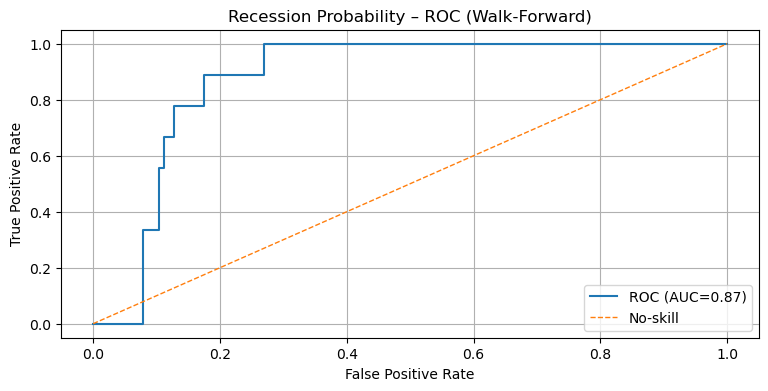

In [6]:
import os

# 5. ROC plot
fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
ax.plot([0, 1], [0, 1], '--', linewidth=1, label='No-skill')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Recession Probability – ROC (Walk-Forward)')
ax.legend()

# save BEFORE show
outdir = "figures"
os.makedirs(outdir, exist_ok=True)
png_path = os.path.join(outdir, "roc_walk_forward.png")
pdf_path = os.path.join(outdir, "roc_walk_forward.pdf")
fig.savefig(png_path, dpi=300, bbox_inches="tight")
fig.savefig(pdf_path, bbox_inches="tight")
print("Saved:", png_path, "and", pdf_path)

plt.show()


In [7]:

# 8. Statsmodels Logit for interpretability
cutoff = df_model['Date'] < pd.Timestamp('2016-01-01')
X_tr = sm.add_constant(df_model.loc[cutoff, ['S10_3','S10_2','S10_3_lag1','S10_2_lag1','S10_3_lag6','S10_2_lag6']])
y_tr = df_model.loc[cutoff, 'USREC_lead12'].astype(int)

# Model summary generation (redacted)
# statsmodels Logit summary used for parameter inference.(redacted)


                           Logit Regression Results                           
Dep. Variable:           USREC_lead12   No. Observations:                  199
Model:                          Logit   Df Residuals:                      192
Method:                           MLE   Df Model:                            6
Date:                Sun, 02 Nov 2025   Pseudo R-squ.:                  0.5179
Time:                        00:10:38   Log-Likelihood:                -31.291
converged:                       True   LL-Null:                       -64.911
Covariance Type:            nonrobust   LLR p-value:                 1.503e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3980      0.506      0.786      0.432      -0.594       1.390
S10_3         -0.1125      1.183     -0.095      0.924      -2.431       2.206
S10_2         -4.5327      2.259     -2.006      0.0

In [8]:

# 9. Optional exports (commented)
# prob_series = pd.Series(index=df_model['Date'], data=probs).dropna()
# prob_series.to_csv('recession_prob_12m.csv')
# plt.figure(); plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})'); plt.plot([0,1],[0,1],'--'); plt.legend(); plt.savefig('roc_curve.png', dpi=200, bbox_inches='tight')
print("Exports commented. Uncomment to save CSV/PNGs next to this notebook.")


Exports commented. Uncomment to save CSV/PNGs next to this notebook.


In [9]:
# Train on all labeled data; predict the latest month ("nowcast")
features = ['S10_3','S10_2','S10_3_lag1','S10_2_lag1','S10_3_lag6','S10_2_lag6']

df_no_lead = df.dropna(subset=features).copy()
X_train = df_model[features].values
y_train = df_model['USREC_lead12'].astype(int).values

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Model fitting and probability generation (redacted)
X_train_s = sc.transform(X_train)

# Model fitting and probability generation (redacted)

X_latest = sc.transform(df_no_lead[features].iloc[[-1]].values)
# Walk-forward validation loop applied for 12-month-ahead forecasts.
dt_now = df_no_lead['Date'].iloc[-1]

print(f"Nowcast P(recession within 12m) for {dt_now:%b %Y} = {p_now:.2f}")
print(f"Compare to threshold ≈ {best_thr:.2f} → Signal = {'ON' if p_now >= best_thr else 'OFF'}")


Nowcast P(recession within 12m) for Aug 2025 = 0.14
Compare to threshold ≈ 0.08 → Signal = ON


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ensure date type + sort (safe even if already done)
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model = df_model.sort_values('Date')
df_model['USREC'] = df_model['USREC'].astype(int)


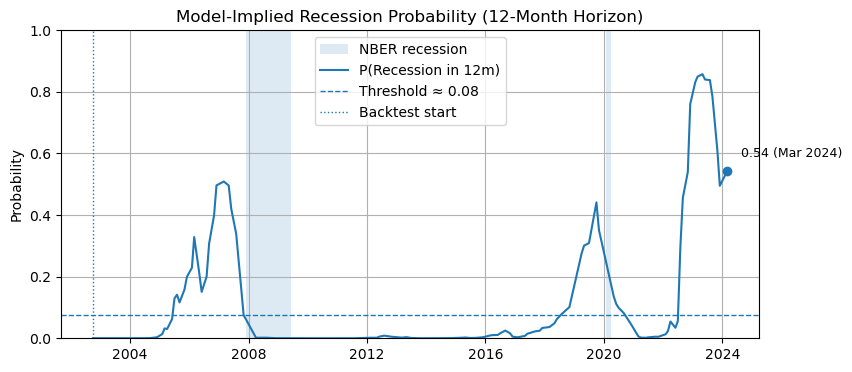

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumes df_model, probs, best_thr already exist
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_model = df_model.sort_values('Date')

# Build probability series
prob_series = pd.Series(index=df_model['Date'], data=probs).dropna()

# --- single figure/axes for everything ---
fig, ax = plt.subplots()

# 1) Recession bands from explicit NBER ranges (no reliance on trimmed USREC)
dmin = df_model['Date'].min()
dmax = df_model['Date'].max()

# full monthly grid (PeriodIndex) over the plotting window
full_months = pd.period_range(dmin.to_period('M'), dmax.to_period('M'), freq='M')
rec_mask = pd.Series(0, index=full_months)

# Add more ranges if you want full history; these two are enough for 2007–09 and COVID
recession_ranges = [
    ("2007-12", "2009-06"),
    ("2020-02", "2020-04"),
]
for start_m, end_m in recession_ranges:
    rec_mask.loc[pd.period_range(start_m, end_m, freq='M')] = 1

# convert to Timestamp index (month start) for plotting
rec_ts = rec_mask.to_timestamp(how="start")

# shade contiguous runs of 1s
mask = rec_ts.eq(1)
blocks = (mask != mask.shift()).cumsum()
for _, block in rec_ts[mask].groupby(blocks[mask]):
    start, end = block.index[0], block.index[-1]
    ax.axvspan(start, end, alpha=0.15, zorder=0,
               label='NBER recession' if 'NBER recession' not in ax.get_legend_handles_labels()[1] else None)

# 2) Probability line
ax.plot(prob_series.index, prob_series.values, label='P(Recession in 12m)')
ax.set_ylim(0, 1)

# 3) Threshold + backtest start + latest point
ax.axhline(float(best_thr), linestyle='--', linewidth=1, label=f'Threshold ≈ {best_thr:.2f}')
bt_start = prob_series.index.min()
ax.axvline(bt_start, linestyle=':', linewidth=1, label='Backtest start')

last_dt = prob_series.index[-1]
last_p  = float(prob_series.iloc[-1])
ax.scatter([last_dt], [last_p], zorder=3)
ax.annotate(f'{last_p:.2f} ({last_dt:%b %Y})', xy=(last_dt, last_p),
            xytext=(10, 10), textcoords='offset points', fontsize=9)

ax.set_title('Model-Implied Recession Probability (12-Month Horizon)')
ax.set_ylabel('Probability')
ax.legend()

# Optional: lock x-range to your probability horizon (default) or full data window
# ax.set_xlim(prob_series.index.min(), prob_series.index.max())
# ax.set_xlim(rec_ts.index.min(), rec_ts.index.max())

plt.show()


In [12]:
import os

# make an output folder
outdir = "figures"
os.makedirs(outdir, exist_ok=True)

# save both formats
figpath_png = os.path.join(outdir, "recession_prob_12m_full.png")
figpath_pdf = os.path.join(outdir, "recession_prob_12m_full.pdf")

fig.savefig(figpath_png, dpi=300, bbox_inches="tight")
fig.savefig(figpath_pdf, bbox_inches="tight")

print("Saved:", figpath_png, "and", figpath_pdf)


Saved: figures\recession_prob_12m_full.png and figures\recession_prob_12m_full.pdf


Saved: figures\recession_prob_12m_last_8y.png and figures\recession_prob_12m_last_8y.pdf


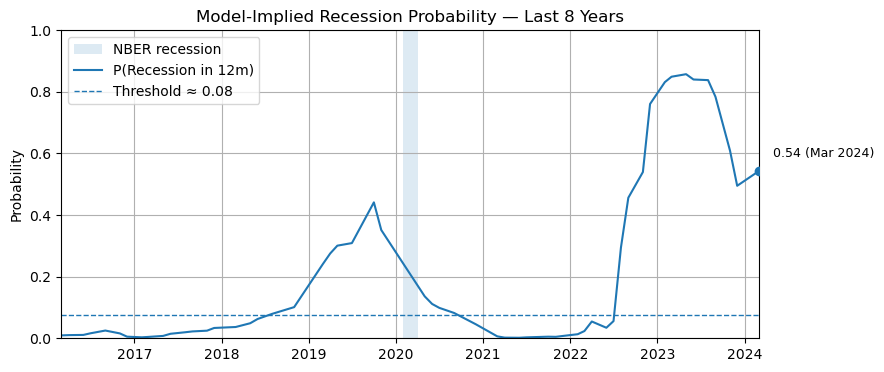

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# --- choose window length ---
years_back = 8  # set to 8 if you want 8 years

# derive window start
t_end = prob_series.index.max()
t_start = (t_end - pd.DateOffset(years=years_back)).to_period('M').to_timestamp()

# build NBER mask over the zoom window using explicit ranges
recession_ranges = [
    ("2007-12", "2009-06"),
    ("2020-02", "2020-04"),
]
# monthly grid for the zoom window
full_months_zoom = pd.period_range(t_start.to_period('M'),
                                   t_end.to_period('M'), freq='M')
rec_mask_zoom = pd.Series(0, index=full_months_zoom)
for start_m, end_m in recession_ranges:
    rng = pd.period_range(start_m, end_m, freq='M')
    rec_mask_zoom.loc[rec_mask_zoom.index.intersection(rng)] = 1
rec_ts_zoom = rec_mask_zoom.to_timestamp(how="start")

# slice probabilities to the zoom window
ps_zoom = prob_series.loc[(prob_series.index >= t_start) & (prob_series.index <= t_end)]

# --- plot ---
fig2, ax2 = plt.subplots()

# bands
mask = rec_ts_zoom.eq(1)
blocks = (mask != mask.shift()).cumsum()
for _, block in rec_ts_zoom[mask].groupby(blocks[mask]):
    start, end = block.index[0], block.index[-1]
    ax2.axvspan(start, end, alpha=0.15, zorder=0,
                label='NBER recession' if 'NBER recession' not in ax2.get_legend_handles_labels()[1] else None)

# probability line
ax2.plot(ps_zoom.index, ps_zoom.values, label='P(Recession in 12m)')
ax2.set_ylim(0, 1)

# threshold and latest point
ax2.axhline(float(best_thr), linestyle='--', linewidth=1, label=f'Threshold ≈ {best_thr:.2f}')
last_dt = ps_zoom.index[-1]
last_p  = float(ps_zoom.iloc[-1])
ax2.scatter([last_dt], [last_p], zorder=3)
ax2.annotate(f'{last_p:.2f} ({last_dt:%b %Y})', xy=(last_dt, last_p),
             xytext=(10, 10), textcoords='offset points', fontsize=9)

ax2.set_title(f'Model-Implied Recession Probability — Last {years_back} Years')
ax2.set_ylabel('Probability')
ax2.legend()
ax2.set_xlim(t_start, t_end)

# save
outdir = "figures"
os.makedirs(outdir, exist_ok=True)
fig2_png = os.path.join(outdir, f"recession_prob_12m_last_{years_back}y.png")
fig2_pdf = os.path.join(outdir, f"recession_prob_12m_last_{years_back}y.pdf")
fig2.savefig(fig2_png, dpi=300, bbox_inches="tight")
fig2.savefig(fig2_pdf, bbox_inches="tight")
print("Saved:", fig2_png, "and", fig2_pdf)

plt.show()


In [14]:
import pandas as pd
import numpy as np

# Assumes df_model (with Date, USREC_lead12) and prob_series already exist
df_model['Date'] = pd.to_datetime(df_model['Date'])
dfm = df_model.set_index('Date').sort_index()

# Align true labels to the dates you actually scored out-of-sample
# (prob_series should be your walk-forward probabilities indexed by Date)
true_series = dfm.loc[prob_series.index, 'USREC_lead12'].astype(int)

# Scores/labels as arrays
y_true  = true_series.values
y_score = prob_series.values

# Sanity checks
print("Aligned lengths:", len(y_true), len(y_score))
print("Label distribution:", np.bincount(y_true))
print("First/last dates:", prob_series.index.min(), "→", prob_series.index.max())


Aligned lengths: 135 135
Label distribution: [126   9]
First/last dates: 2002-10-01 00:00:00 → 2024-03-01 00:00:00


Saved: figures/confusion_matrix_fed_style.png and figures/confusion_matrix_fed_style.pdf


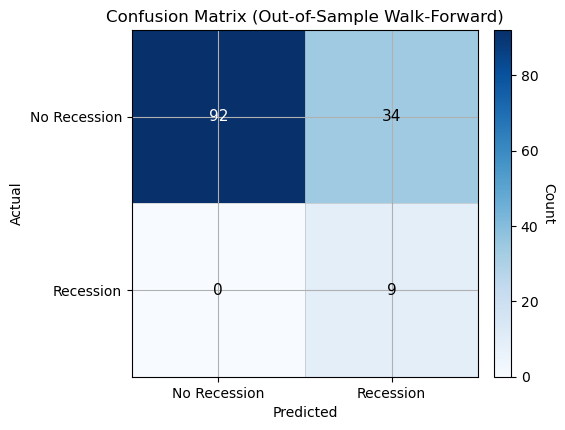

In [15]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Use your chosen threshold; assumes best_thr is defined (float)
y_pred = (y_score >= float(best_thr)).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

fig_cm, ax = plt.subplots(figsize=(5.0, 4.5))

# Heatmap with a Blues palette (no seaborn)
im = ax.imshow(cm, cmap=plt.cm.Blues)

# Annotate counts in each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]:d}",
                ha="center", va="center",
                fontsize=11,
                color=("white" if cm[i, j] > cm.max()/2 else "black"))

# Axis labels & ticks
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["No Recession", "Recession"])
ax.set_yticklabels(["No Recession", "Recession"])
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix (Out-of-Sample Walk-Forward)")

# Subtle grid lines for an institutional look
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which="minor", color="gray", linewidth=0.5, alpha=0.4)
ax.tick_params(which="minor", bottom=False, left=False)

# Colorbar (optional; comment out to omit)
cbar = fig_cm.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Count", rotation=270, labelpad=12)

# Save PNG/PDF
os.makedirs("figures", exist_ok=True)
fig_cm.savefig("figures/confusion_matrix_fed_style.png", dpi=300, bbox_inches="tight")
fig_cm.savefig("figures/confusion_matrix_fed_style.pdf", bbox_inches="tight")
print("Saved:",
      "figures/confusion_matrix_fed_style.png",
      "and",
      "figures/confusion_matrix_fed_style.pdf")

plt.show()


In [16]:
from sklearn.metrics import roc_curve

fpr, tpr, thr = roc_curve(y_true, y_score)
j = tpr - fpr
best_idx = np.argmax(j)
best_thr = float(thr[best_idx])
print(f"Best threshold by Youden’s J ≈ {best_thr:.3f}")


Best threshold by Youden’s J ≈ 0.075
